# Refinement of PbSO4 with emcee

In this example we take a bayesian approach to the refinment process, and rather than looking for the optimal set of parameters we compute the probability distribution over the parameters.

## Bayesian refinment

**Goal:** Finding the posterior probability distribution over parameters, $P(\boldsymbol{x}|D)$,  given some data D  and prior knowledge.

* Experimental data D ($y^\text{exp}$) 
* $\boldsymbol{x}$ parameters to be refined $\boldsymbol{x}$=($\boldsymbol{x}_\text{experiment}$, $\boldsymbol{x}_\text{instrument}$, $\boldsymbol{x}_\text{sample}$)
* Simulated diffraction pattern $y^\text{sim}=f(\boldsymbol{x})$


The posterior for parameters is
\begin{equation}
\large
\underbrace{P(\boldsymbol{x}|D)}_\text{Posterior} = \underbrace{P(D|\boldsymbol{x})}_\text{Likelihood}\, \, \underbrace{P(\boldsymbol{x})}_\text{Priors}
\end{equation}

### Likelihood
We assume independent and (almost)identical normal distributed errors. But we take into account heteroscedasticity that is commonly done for diffraction data, i.e. uncertainty scales with sqrt of intensity, which be achived by modeling the data as
\begin{equation}
\large
y^\text{exp}_i = y^\text{sim}_i + \epsilon_i \\
\large
\epsilon_i \sim \mathcal{N}(\mu=0, \sigma^2_i = \sigma^2 \cdot y^\text{exp}_i).
\end{equation}
where $\epsilon_i$ is the error between the experimental (exp) and simulated (sim) diffraction patterns.

And then we get a likelihood that looks like
\begin{equation}
\large
P(D|\boldsymbol{x}) \propto \exp{\left (- \frac{\sum_i (y^\text{sim}_i- y^\text{exp}_i)^2 }{\sigma^2 y^\text{exp}_i}\right )}
\end{equation}
Note here that $\sigma$ is also a free parameter that we need to include in our modeling.


### Priors
In this example we encode no information in the priors, but in princple any prior knowledge about the same could and should be encoded in the prior probability distribution.


### Posterior 
Finding parameters that maximizes the posterior is equvivalent to regular optimization (least-squares).

Obtaining the posterior probability distribution is done via MCMC-sampling with `emcee`, see their [documentation](https://emcee.readthedocs.io/en/stable/) for more details.

### More information
See the "Use of Bayesian Inference in Crystallographic Structure Refinement via Full Diffraction Profile Analysis" (doi: https://doi.org/10.1038/srep31625), for more information.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emcee
import corner
sns.set_context('notebook')

# esyScience, diffraction
from easyDiffractionLib import Phases
from easyDiffractionLib.sample import Sample as Job
from easyDiffractionLib.interface import InterfaceFactory as Calculator
from easyDiffractionLib.elements.Experiments.Pattern import Pattern1D
from easyDiffractionLib.elements.Backgrounds.Point import PointBackground, BackgroundPoint
from easyDiffractionLib.Profiles.P1D import Instrument1DCWParameters as CWParams

ModuleNotFoundError: No module named 'seaborn'

## Import EasyDiffraction

In [ ]:
import easydiffraction as ed

## Import other libraries

In [32]:
import corner  # Library for plotting posterior distributions
import emcee  # Library for MCMC sampling
import matplotlib.pyplot as plt  # Plotting library
import numpy as np  # Numerical library

## Helper functions
Here we let `theta` be the parameter vector (including $\sigma$).

In [33]:
# helper functions

def print_parameters(job):
    """ Print all fit-parameters in job. """
    for x in job.get_fit_parameters():
        print(x)
    

def compute_rmse(y_target, y_predicted):
    """ Compute root mean squared error (RMSE) between target and predicted values """
    delta_y = y_target - y_predicted
    rmse = np.sqrt(np.mean(delta_y**2))
    return rmse

def compute_mse_weighted(y_target, y_predicted):
    """ Compute the weighted mean squared error. (weighting by y_target) """
    delta_y = y_target - y_predicted
    weight = y_target
    mse_weighted = np.mean(delta_y**2 / weight)
    return mse_weighted

In [34]:
# theta_0 is close to least-square solution
theta_0 = np.array([2.0, 8.477, 5.3958, 6.9558, 1.21, 0.157, 0.195, -0.47, 0.47, 200, 240])
parameter_names = ['sigma', 'length_a', 'length_b', 'length_c', 'scale', 'zero_shift',
                   'resolution_u', 'resolution_v', 'resolution_w', 'intensity', 'intensity-1']

def generate_starting_theta():
    """ Generate random initial starting point pretty close to theta_0 """

    # parameters defining how much randomness to add to theta_0
    dx_sigma = 1
    dx_lattice_parameter = 0.01
    dx_scale = 0.05
    dx_zeroshift = 0.03
    dx_reso = 0.001
    dx_bkg = 20
    
    # randomize theta
    theta = theta_0.copy()
    theta[0] += np.random.uniform(-dx_sigma, dx_sigma)
    
    for i in [1, 2, 3]:
        theta[i] += np.random.uniform(-dx_lattice_parameter, dx_lattice_parameter)

    theta[4] += np.random.uniform(-dx_scale, dx_scale)
    theta[5] += np.random.uniform(-dx_zeroshift, dx_zeroshift)
    
    theta[6] += np.random.uniform(-dx_reso, dx_reso)
    theta[7] += np.random.uniform(-dx_reso, dx_reso)
    theta[8] += np.random.uniform(-dx_reso, dx_reso)
    
    theta[9] += np.random.uniform(-dx_bkg, dx_bkg)
    theta[10] += np.random.uniform(-dx_bkg, dx_bkg)
    return theta


def set_job_parameters(job, theta):
    """
    Set all the parameters for the job.
    theta[0] is sigma and is thus not used 
    """

    job.phases[0].cell.length_a = theta[1]
    job.phases[0].cell.length_b = theta[2]
    job.phases[0].cell.length_c = theta[3]

    job.phases[0].scale = theta[4]
    job.pattern.zero_shift = theta[5]
    job.parameters.resolution_u = theta[6]
    job.parameters.resolution_v = theta[7]
    job.parameters.resolution_w = theta[8]
    job.backgrounds[0][0].y = theta[9]
    job.backgrounds[0][1].y = theta[10]

## Probability functions

In [35]:
# define all probabilities, priors, likelihoods, posterios

def log_gaussian_likelihood(theta):

    # set parameters
    sigma = theta[0]
    set_job_parameters(job, theta)
    
    # if calculation fails for any reason, return -inf
    try:
        y_predicted = job.calculate_profile(meas_x)
    except ArithmeticError:
        print('  Exception from calc found, -inf')
        return -np.inf

    # if y contains nan then return -inf
    if np.any(np.isnan(y_predicted)):
        print('  nan found in predicted values, -inf')
        return -np.inf

    # compute log-likelihood
    sigmas = sigma * np.sqrt(meas_y)
    LL = -0.5 * np.sum(np.log(2 * np.pi * sigmas ** 2) + (meas_y - y_predicted) ** 2 / sigmas ** 2)
    return LL


def log_prior(theta):
    sigma = theta[0]
    if sigma < 0 or sigma > 1000:
        return -np.inf
    return 0


def log_posterior(theta):
    return log_prior(theta) + log_gaussian_likelihood(theta)

## Load the data and setup Job

In [36]:
# create job
job = ed.Job()

# load cif
cif_fname = 'data/PbSO4.cif'
job.add_phase_from_file(cif_fname)

# load diffraction data
meas_fname = 'data/D1A@ILL.xye'
meas_x, meas_y, meas_e = np.loadtxt(meas_fname, unpack=True)
print('Data shape:', meas_x.shape, meas_y.shape)

Data shape: (2910,) (2910,)


In [37]:
# setup 
job.parameters.wavelength = 1.912

# add background
job.set_background([(meas_x[0], 200),
                    (meas_x[-1], 250)])

Note here that no parameters are set to be refined. The MCMC simulations will be carried out using `emcee` package which will use the `log_posterior` function to sample the posterior.
The `job` will only be used to calculate the diffraction pattern for the parameters that `emcee` will sample.

Initial: RMSE 114.950, MSE-weighted 19.462


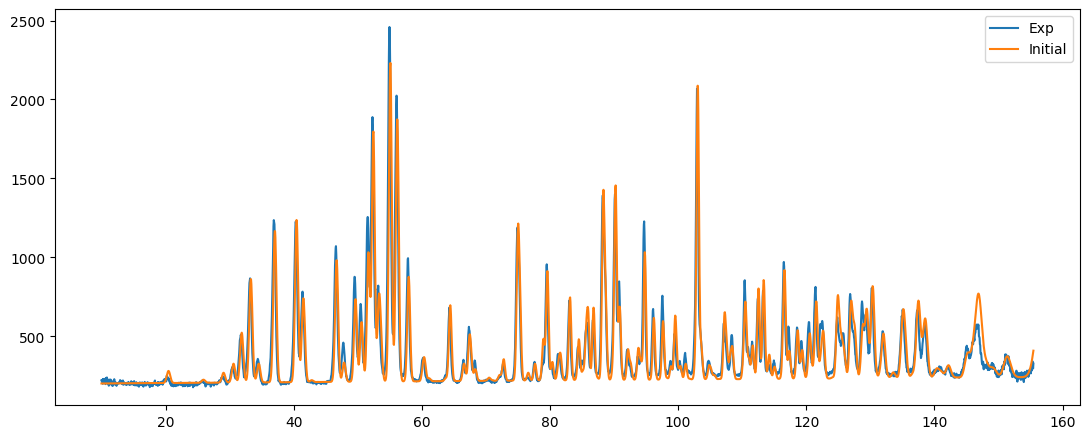

In [38]:
# Sanity check if theta_0 is reasonable 
set_job_parameters(job, theta_0)
y_initial = job.calculate_profile(meas_x)
rmse_initial = compute_rmse(meas_y, y_initial)
msew_initial = compute_mse_weighted(meas_y, y_initial)
print(f'Initial: RMSE {rmse_initial:.3f}, MSE-weighted {msew_initial:.3f}')

# plot
fig = plt.figure(figsize=(11, 4.5))
plt.plot(meas_x, meas_y, label='Exp')
plt.plot(meas_x, y_initial, label='Initial')
plt.legend()
fig.tight_layout()

## Run MCMC sampling

Next, we define the hyper-parameters to be used for the MCMC sampling

The MCMC is carried out by multiple independent "walkers".

* `n_steps` sets how many steps/iterations each walker will carry out
* `n_walkers` sets how many walkers to use
* `n_parameters` is the total number of parameters being optimized
* `n_every` how often to record store the MCMC trajectory


In [39]:
# MCMC parameters
n_walkers = 15             # number of MCMC walkers
n_every = 1               # keep every x:th sample
n_steps = 5000 // n_every  # steps per walker
n_parameters = 11         # number of parameters

Next, we generate the starting parameters for all walkers.

In [40]:
# generate starting points for walkers
theta_start = [theta_0.copy()]
for _ in range(n_walkers-1):
    theta_start.append(generate_starting_theta())
theta_start = np.array(theta_start).copy()
print('theta start shape:', theta_start.shape)

# sanity check starting points such that there is no horribly starting points with e.g. NaNs
for it, theta in enumerate(theta_start):
    set_job_parameters(job, theta)
    y = job.calculate_profile(meas_x)
    rmse = compute_rmse(meas_y, y)
    msew = compute_mse_weighted(meas_y, y)
    logp = log_posterior(theta)
    
    print(f'Walker {it:2}: log-posterior {logp:11.5f} | RMSE {rmse:.3f} | MSE-weighted {msew:.3f}')

theta start shape: (15, 11)
Walker  0: log-posterior -23931.48091 | RMSE 140.301 | MSE-weighted 29.725
Walker  1: log-posterior -32193.61124 | RMSE 164.083 | MSE-weighted 42.404
Walker  2: log-posterior -28292.46408 | RMSE 146.605 | MSE-weighted 32.991
Walker  3: log-posterior -24666.47328 | RMSE 166.305 | MSE-weighted 44.407
Walker  4: log-posterior -21216.00691 | RMSE 147.781 | MSE-weighted 32.755
Walker  5: log-posterior -61294.04408 | RMSE 165.168 | MSE-weighted 41.269
Walker  6: log-posterior -42380.19343 | RMSE 142.942 | MSE-weighted 32.279
Walker  7: log-posterior -20564.70922 | RMSE 124.719 | MSE-weighted 25.830
Walker  8: log-posterior -20669.12317 | RMSE 159.226 | MSE-weighted 39.037
Walker  9: log-posterior -27531.67088 | RMSE 115.179 | MSE-weighted 20.835
Walker 10: log-posterior -19665.11177 | RMSE 90.505 | MSE-weighted 12.576
Walker 11: log-posterior -23301.31594 | RMSE 117.038 | MSE-weighted 20.500
Walker 12: log-posterior -22165.26440 | RMSE 171.991 | MSE-weighted 46.58

In order make emcee run with fewer walkers than twice the number of parameters, we need to set `sampler._moves[0].live_dangerously = True `, but this is often unadvisable.

Due the starting points for the walkers being quite similar we also may need to set `skip_initial_state_check=True` in order to avoid poor conditioned starting point error.


In [41]:
# sample
sampler = emcee.EnsembleSampler(n_walkers, n_parameters, log_posterior)
sampler._moves[0].live_dangerously = True 
sampler.run_mcmc(theta_start, n_steps, progress=True, thin_by=n_every, skip_initial_state_check=True)
print('Done!')

100%|██████████| 5000/5000 [2:05:11<00:00,  1.50s/it]     

Done!


In [42]:
samples = sampler.chain
logp = sampler.lnprobability
steps = n_every * np.arange(0, samples.shape[1])
print('samples shape:', samples.shape)

samples shape: (15, 5000, 11)


First we'll plot the posterior of all walkers to check convergence.

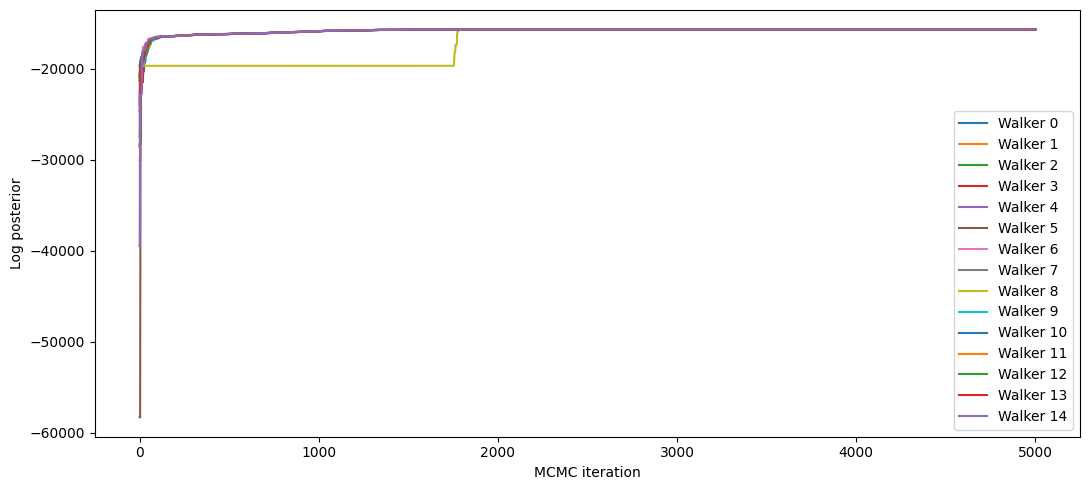

In [43]:
fig = plt.figure(figsize=(11, 5))
for walker_ind in range(n_walkers):
    plt.plot(steps, logp[walker_ind, :], label=f'Walker {walker_ind}')
plt.legend()
plt.ylabel('Log posterior')
plt.xlabel('MCMC iteration')
fig.tight_layout()

Next, we'll plot the MCMC trajectory of the parameters for a few walkers

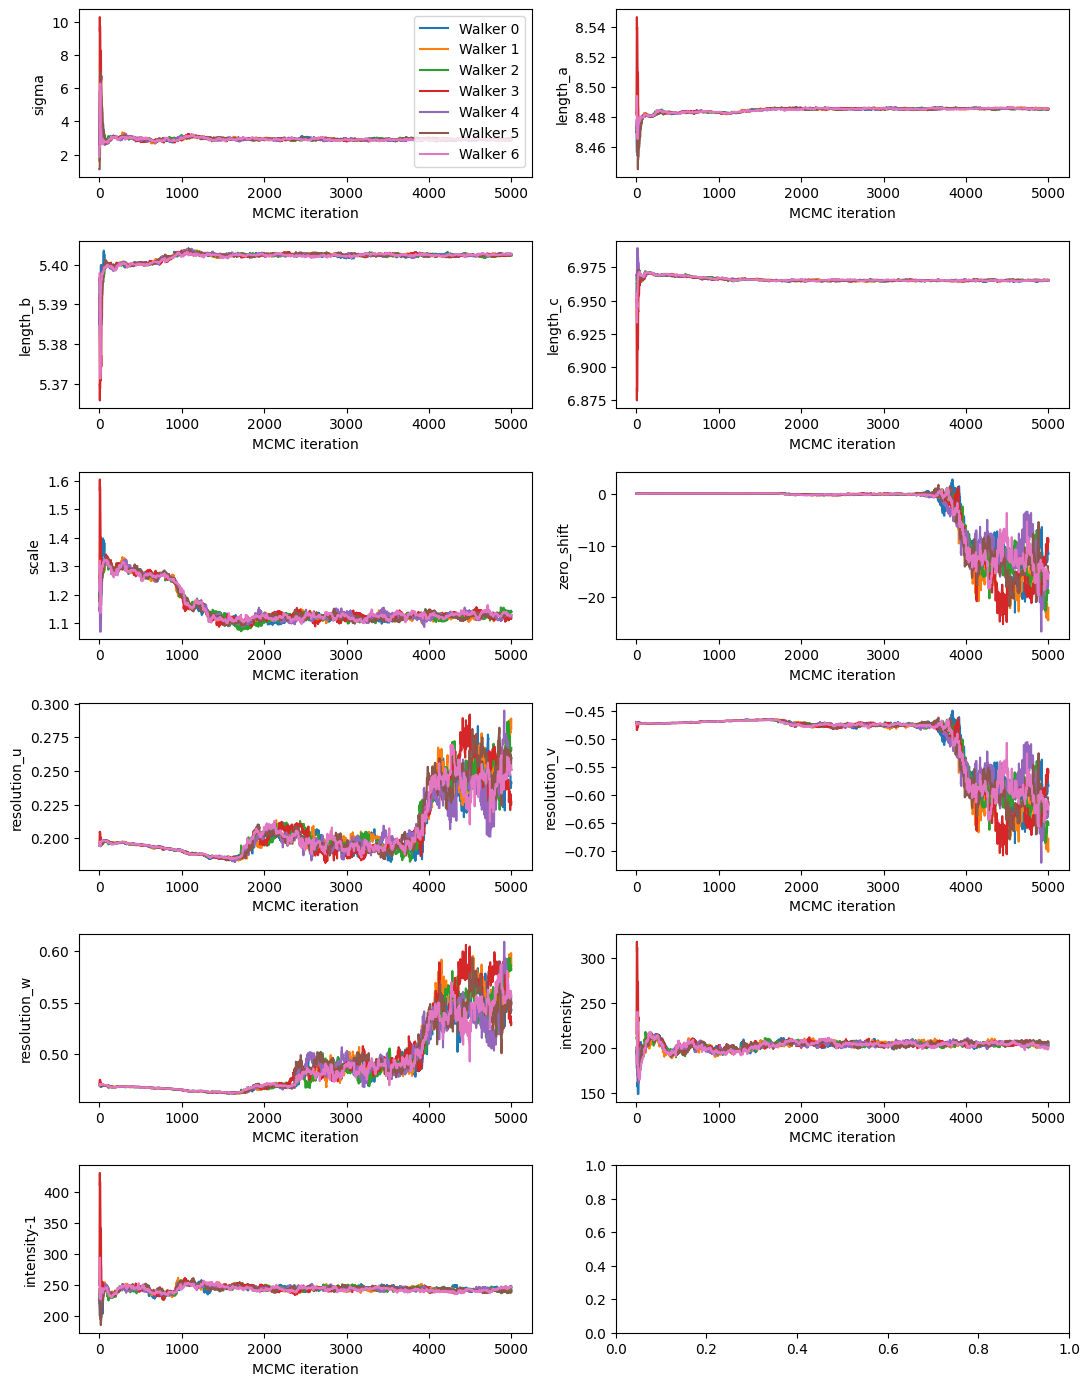

In [44]:
walkers_to_plot = [0, 1, 2, 3, 4, 5, 6]

fig, axes = plt.subplots(6, 2, figsize=(11, 14))
for i in range(n_parameters):
    ax = axes.flat[i]
    name = parameter_names[i]
    for walker_ind in walkers_to_plot:
        ax.plot(steps, samples[walker_ind, :, i], label=f'Walker {walker_ind}')
    ax.set_ylabel(name)
    ax.set_xlabel('MCMC iteration')
    if i == 0:
        ax.legend(loc=1)
    
fig.tight_layout()
plt.show()

Now we extract the optimal choice of parameters and their standard-deviation.    
We throw away the equilibration period of the MCMC simulations.



In [45]:
n_throw_away = 2000 // n_every  # number of equilibration steps to throw away
samples_flat = samples[:, n_throw_away:, :].reshape(-1, n_parameters)
print('samples    shape: ', samples.shape)
print('samples_flat shape:', samples_flat.shape)

samples    shape:  (15, 5000, 11)
samples_flat shape: (45000, 11)


In [46]:
# select best model
ind = np.argmax(logp)
hp_loc = np.unravel_index(ind, logp.shape)
assert logp[hp_loc] == logp.max()
theta_best = samples[hp_loc]

# calculate spectra with best model
set_job_parameters(job, theta_best)
y = job.calculate_profile(meas_x)
rmse_refined = compute_rmse(meas_y, y)
msew_refined = compute_mse_weighted(meas_y, y)
print(f'Best model: RMSE {rmse_refined:.3f}, MSE-weighted {msew_refined:.3f}, sigma {theta_best[0]:.3f}')

# estimate errors of parameters
stds = samples_flat.std(axis=0)

# Save the data to be analyzed
data = dict(names=parameter_names, steps=steps, samples=samples, logp=logp)
parameter_dict = dict()
for name, val, err in zip(parameter_names, theta_best, stds):
    key = name
    if name in parameter_dict:
        key = key + '-1'
    print(f'{key:15} {val:12.5f} , err {err:8.5f}')
    parameter_dict[key] = val, err
data['parameters'] = parameter_dict
np.save(f'refinement_results/emcee_steps{n_steps}_walkers{n_walkers}.npy', data, allow_pickle=True)

Best model: RMSE 76.026, MSE-weighted 8.450, sigma 2.914
sigma                2.91408 , err  0.03949
length_a             8.48558 , err  0.00031
length_b             5.40231 , err  0.00022
length_c             6.96515 , err  0.00032
scale                1.13024 , err  0.00961
zero_shift         -13.37478 , err  6.99562
resolution_u         0.24371 , err  0.02581
resolution_v        -0.59684 , err  0.06415
resolution_w         0.54748 , err  0.03474
intensity          203.47388 , err  1.96716
intensity-1        243.25657 , err  2.46472


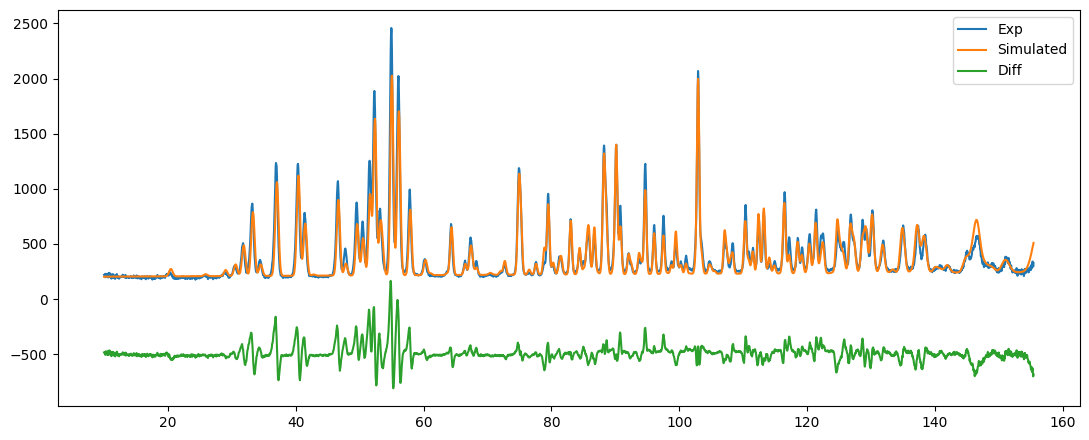

In [47]:
# plot refined diffraction pattern
fig = plt.figure(figsize=(11, 4.5))
plt.plot(meas_x, meas_y, label='Exp')
plt.plot(meas_x, y, label='Simulated')
plt.plot(meas_x, meas_y - y-500, label='Diff')
plt.legend()
fig.tight_layout()

<Figure size 1200x1200 with 0 Axes>

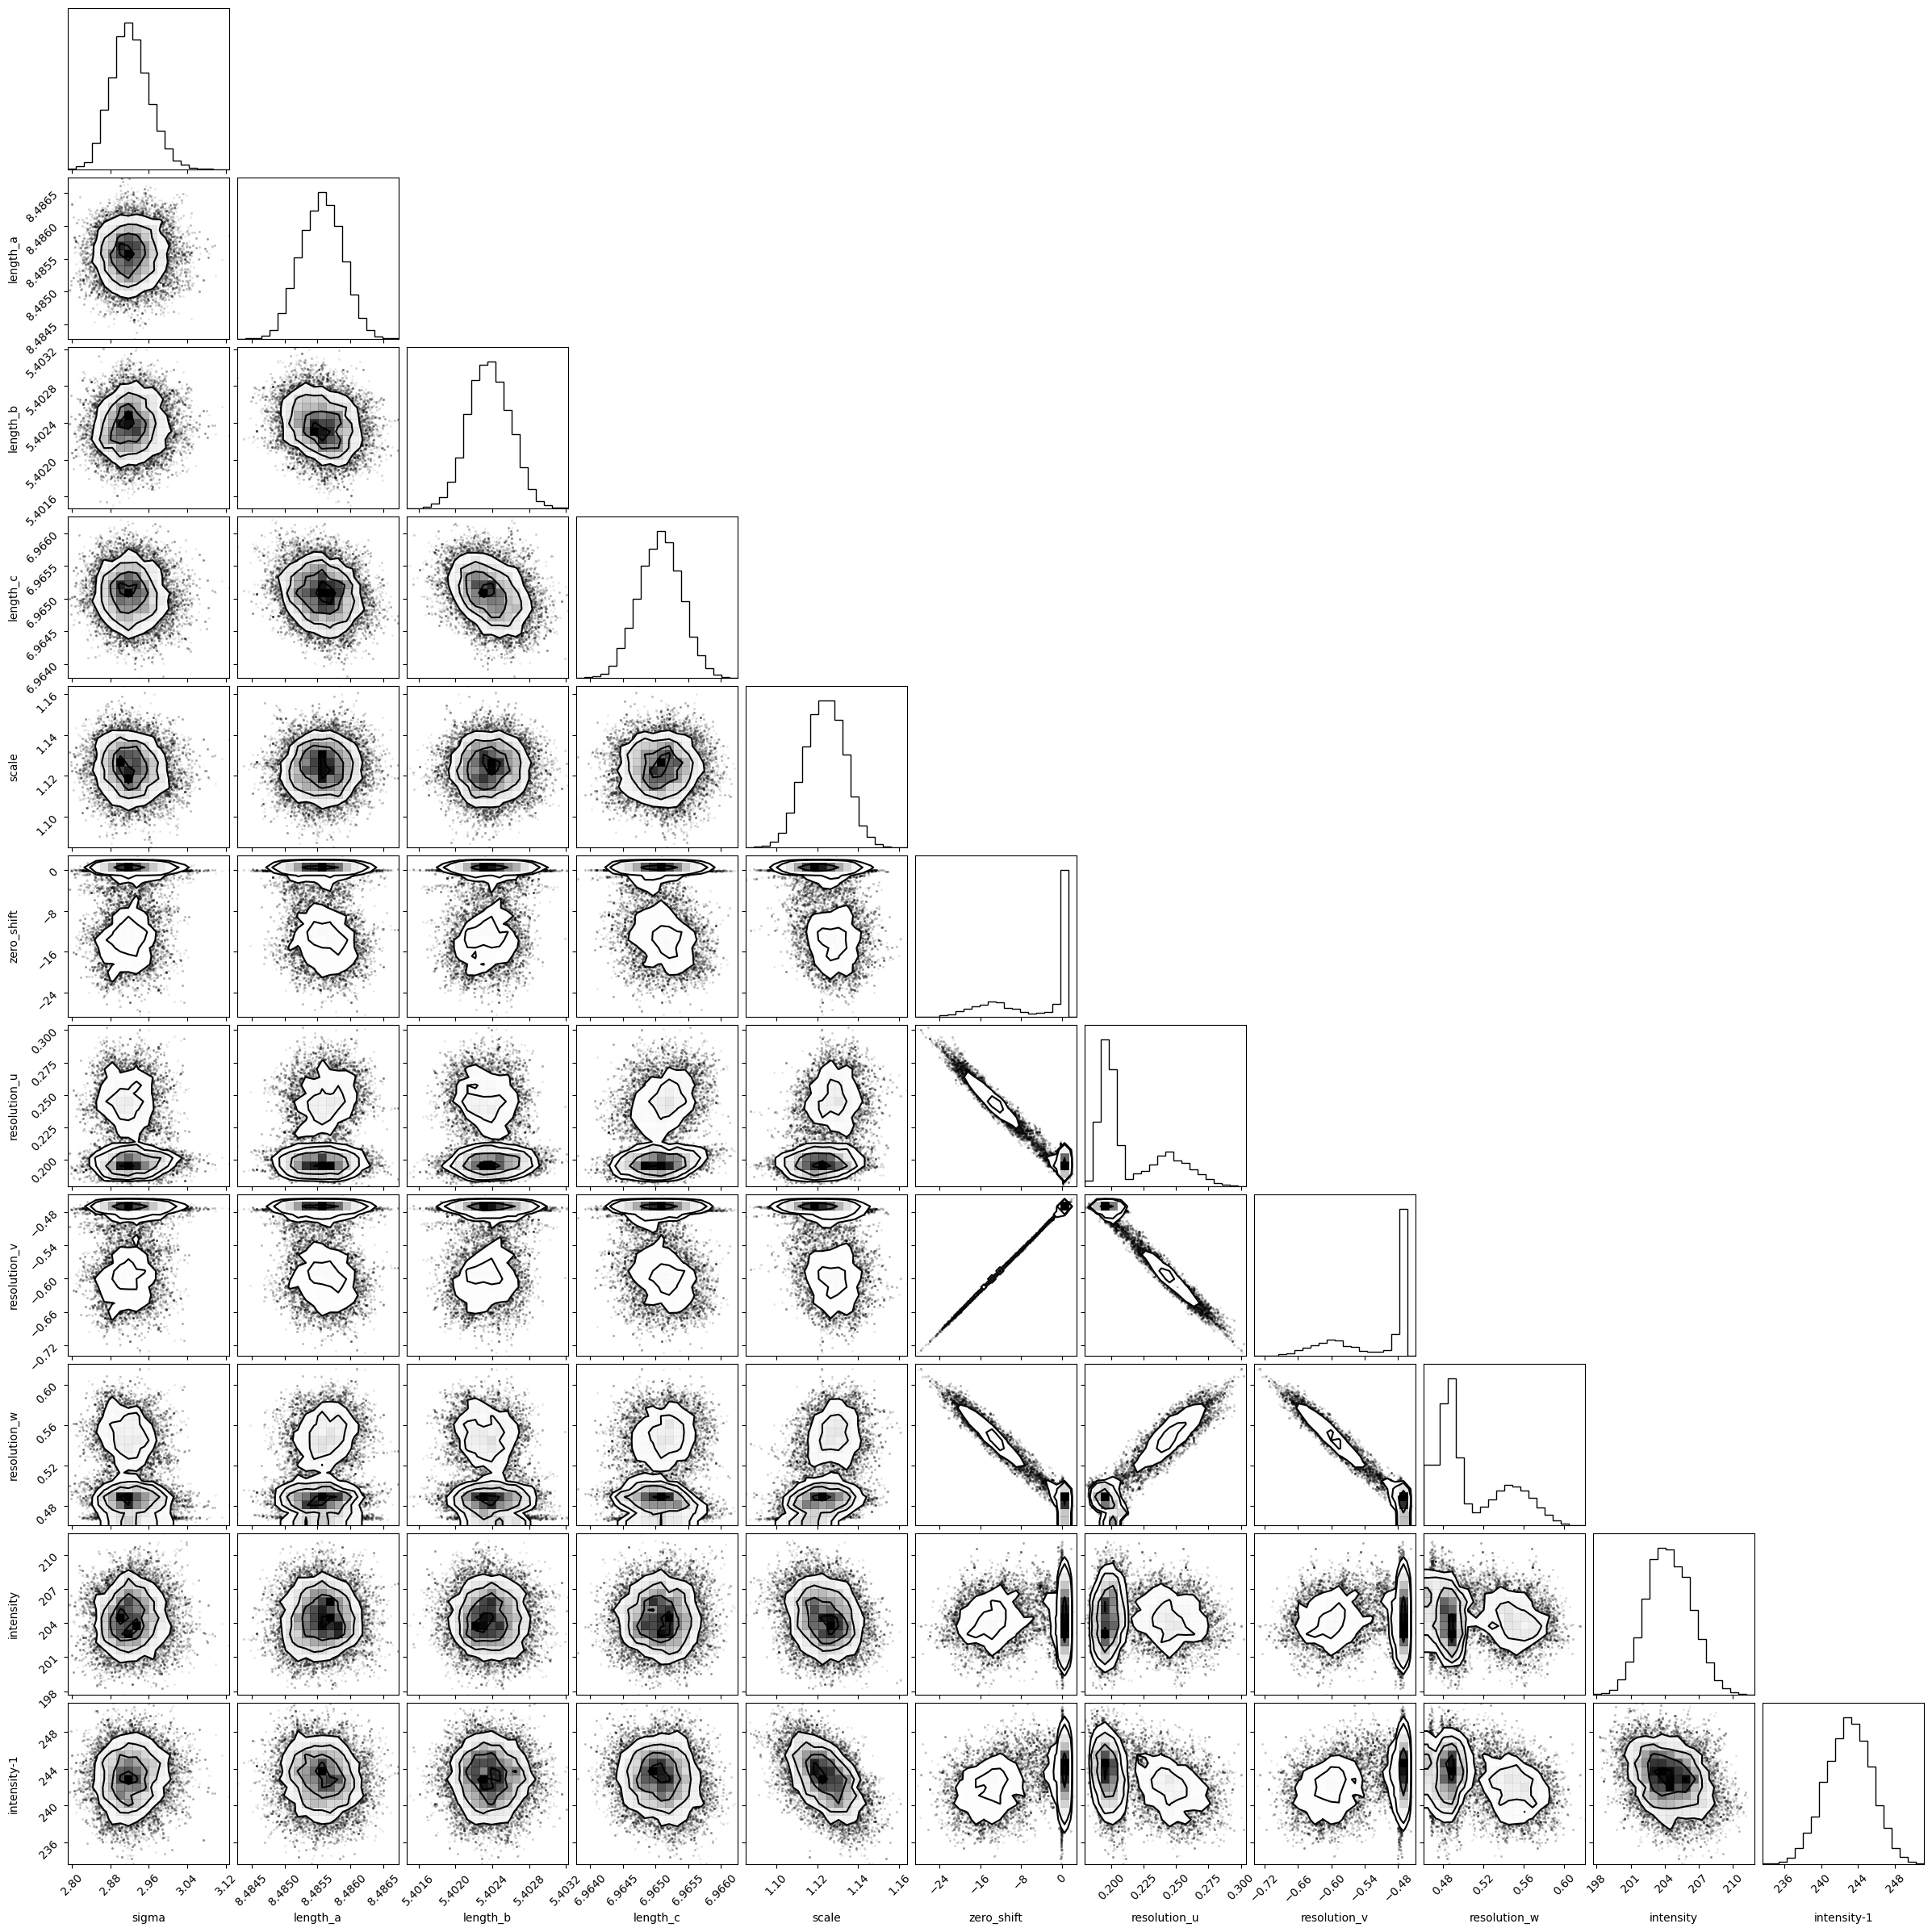

In [49]:
import corner
# corner plot
fig = plt.figure(figsize=(12, 12))
corner.corner(samples_flat, labels=parameter_names)
fig.tight_layout()